In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import gpytorch

In [ ]:
# This sets a variable for randomization which makes our results reproducible
torch.manual_seed(45)
def get_target_function(x):
    # True function is x * sin(x + 5) with Gaussian noise
    return x*torch.sin(x+5)

x = torch.linspace(-5, 5, 10000)
y = get_target_function(x) + torch.normal(0, 1, size=x.size())
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [ ]:
x_test = torch.linspace(-5, 5, 10000)
y_test = get_target_function(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

In [ ]:
def define_model(dropout_prob):
    model_nn = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100),
        nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100),
        nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100),
        nn.Tanh(),
        nn.Dropout(p=dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1),
    )
    # copying the other neural network for comparision
    model_nn = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
        nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1000),
        nn.Tanh(),
        nn.Dropout(p=dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
    )
    return model_nn

def plot_model(mean_values, std_values):
    plt.figure(figsize=(10,6))
    plt.scatter(x, y, alpha=0.8)
    plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
    #plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
    plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
    plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
    #plt.plot(x_test.data.numpy(),get_target_function(x_test),color='green',markersize=4,label='Target function')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def get_dist(x_test, model):
    models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
    models_result = models_result[:,:,0]    
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])
    return mean_values, std_values

probs = [0, 0.2, 0.5, 0.8]
mean_values_list = []
std_values_list = []
for prob in probs:
    model_nn = define_model(prob)
    
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    # kl weight started as 0.01
    kl_weight = 0.01
    optimizer_nn = optim.Adam(model_nn.parameters(), lr=0.01)
    for step in range(4000):
        pre = model_nn(torch.unsqueeze(x, dim=1))
        mse = mse_loss(pre, torch.unsqueeze(y, dim=1))
        kl = kl_loss(model_nn)
        cost = mse + kl_weight*kl
        optimizer_nn.zero_grad()
        cost.backward()
        optimizer_nn.step()

    mean_values, std_values = get_dist(x_test, model_nn)

    plot_model(mean_values, std_values)

    mean_values_list.append(mean_values)
    std_values_list.append(std_values)
    



In [ ]:
residuals = np.abs((np.array(y_test) - mean_values.reshape(-1, 1)))

In [ ]:
plt.plot(np.array(x_test), residuals)

In [ ]:
print(np.mean(residuals))

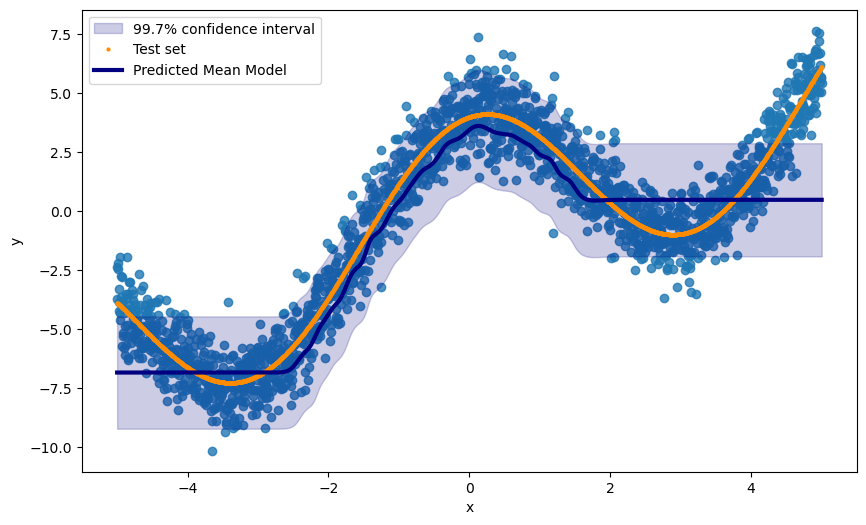

In [466]:
plot_model(mean_values, std_values)

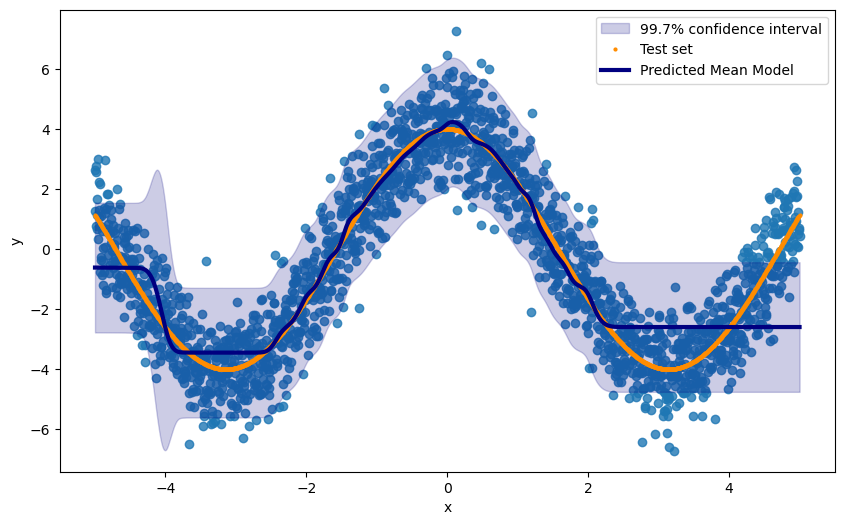

In [458]:
plot_model(mean_values, std_values)

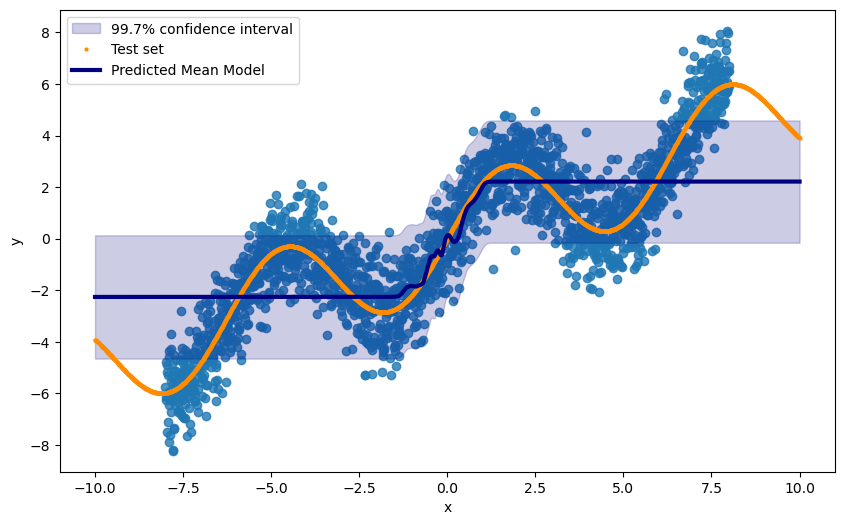

In [387]:
plot_model(mean_values, std_values)

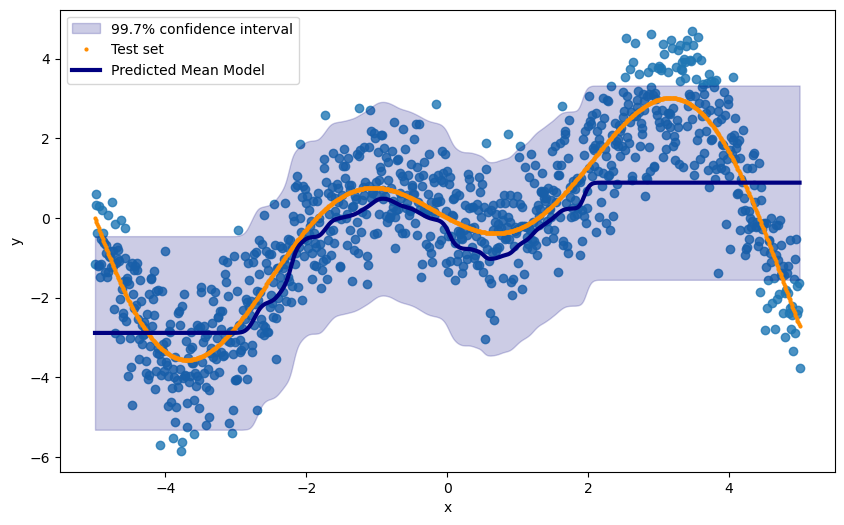

In [228]:
plot_model(mean_values, std_values)

In [ ]:
plot_model(mean_values, std_values)

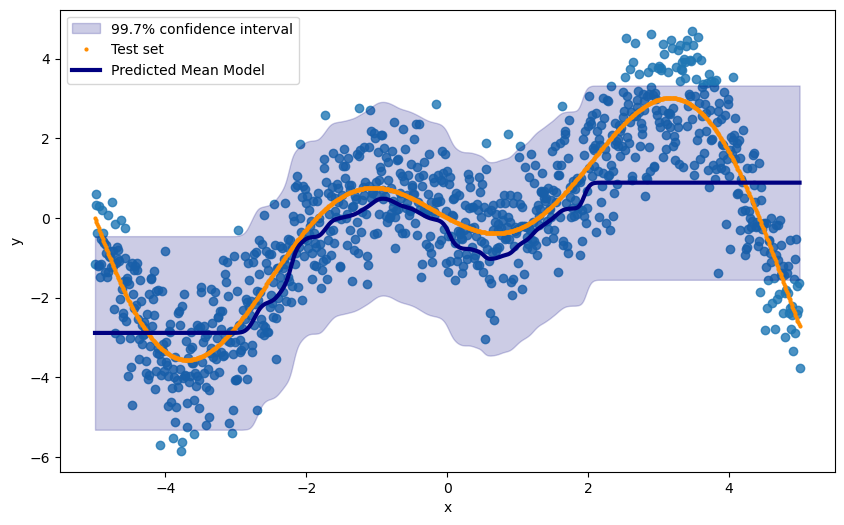

In [227]:
plot_model(mean_values, std_values)